In [1]:
## import statements 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from functools import reduce
import sklearn
import matplotlib
import os
import warnings
from multiprocessing import Pool
import tqdm
warnings.filterwarnings('ignore')
import seaborn as sns
from matplotlib import cm 
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib
from matplotlib.lines import Line2D 
import os
from sklearn import tree
from sklearn.metrics import mean_squared_error 
from  matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from numpy import arange
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn import preprocessing
from sklearn import linear_model
import scipy
import pickle
from IIASA_22_fxns import split_data, get_N_exp, get_season_info, get_gs_climate, row_gsy_climate, tt_split_scale, random_forest, yield_run_data, all_run_data

In [2]:
#### PULL FULL DATASETS FOR ALL CROPS 
crop_list = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE']
all_treat_list = []
for crop in crop_list: 
    all_treats = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//"+ crop + "//"+ crop + "_all_treat_data.csv")
    all_treat_list.append(all_treats)


In [3]:
# input full treatment data, return clusters which regressions were trained with 
def get_clusters(all_treats):    
    #### ARGUMENTS FOR CLUSTERING 
    clust_args = []
    for clim in all_treats.k_mean_cluster.unique(): 
        for tex in all_treats.TEXTURE.unique(): 
            clust_args.append((clim, tex))

    #### CLUSTERING - A PRIORI AND UNSUPERVISED 
    # CLUSTER BY CLIMATE - 10 clusters, SOIL - 6 classes, CROP
    cluster_dfs = []
    for arg in clust_args: 
        clim = arg[0]
        tex = arg[1]
        df_clust = all_treats[(all_treats.k_mean_cluster == clim) & (all_treats.TEXTURE == tex)]
        # remove outliers
        cleaned = df_clust[(np.abs(scipy.stats.zscore(df_clust['YLDG'])) < 3) & (np.abs(scipy.stats.zscore(df_clust['mean_OCPD_change'])) < 3)]
        # enforce that there must be at least 1000 points in a cluster to complete analysis
        if len(cleaned) > 1000: 
            cleaned.dropna(inplace = True)
            cluster_dfs.append(cleaned)    
    # append full data 
    all_treats.dropna(inplace = True)
    cluster_dfs.append(all_treats)
    
    return(cluster_dfs)


In [4]:
# cluster_lists 
# first level = crop 
# second level = cluster, last cluster is full data set 
cluster_lists = []
for crop in all_treat_list:
    cluster_dfs = get_clusters(crop)
    cluster_lists.append(cluster_dfs)

In [5]:
# unpickle the variables from regressions for each crop - inside each of these is information on cluster 
# specific regression, full regression. Return unpickled data.

def unpickle(crop):    
    # Open a file and use dump()
    with open(('predict_y_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        predict_y_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('x_trains_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        x_trains_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('x_tests_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        x_tests_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('y_trains_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        y_trains_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('y_tests_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        y_tests_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('train_inds_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        train_inds_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('scores_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        scores_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('regressors_AT_' + crop + '.pkl'), 'rb') as file:
        # A new file will be created
        regressors_AT = pickle.load(file)
    # Open a file and use dump()
    with open(('loo_scores_AT_' + crop + '2.pkl'), 'rb') as file:
        # A new file will be created
        loo_scores_AT = pickle.load(file)

        
    return([predict_y_AT, x_trains_AT, x_tests_AT, y_trains_AT, y_tests_AT, train_inds_AT, scores_AT, regressors_AT, loo_scores_AT])

In [6]:
# pickle_list 
# first level is crop 
# second level is parameter from model - e.g. x_train_AT
# third level is target 
# fourth level is cluster 

# PULL ALL PICKLES BACK IN FROM MODEL RESULTS 
pickle_list = []
for crop in crop_list: 
    pickle_list.append(unpickle(crop))
    
# ..._pckl
# first level is crop 
# second level is target 
# third level is cluster
    
predict_y_pckl = [pckl[0] for pckl in pickle_list]
x_trains_pckl = [pckl[1] for pckl in pickle_list]
x_tests_pckl = [pckl[2] for pckl in pickle_list]
y_trains_pckl = [pckl[3] for pckl in pickle_list]
y_tests_pckl = [pckl[4] for pckl in pickle_list]
train_inds_pckl = [pckl[5] for pckl in pickle_list]
scores_pckl = [pckl[6] for pckl in pickle_list]
regressors_pckl = [pckl[7] for pckl in pickle_list]
loo_scores_pckl = [pckl[8] for pckl in pickle_list]

# Accuracy & Bias Plots

In [9]:
# scores of full models 
full_scores = [scores[1][-1] for scores in scores_pckl]

In [10]:
# get scores of biophysical meta-models
meta_scores = [scores[1][:-1] for scores in scores_pckl]

In [11]:
# flatten scores of biophysical meta-models across crops and clusters
flat_meta = [item for sublist in meta_scores for item in sublist]

In [12]:
# get mean score across crops for each cluster
clust_mean_meta_scores = []
avg_train_len = []
for i in range(44): 
    mean_score = sum([scores[1][i] for scores in scores_pckl])/len(scores_pckl)
    clust_mean_meta_scores.append(mean_score)
    mean_train_len = sum([len(trains[1][i]) for trains in x_trains_pckl])/len(scores_pckl)
    avg_train_len.append(mean_train_len)

In [13]:
# input target, cluster_dfs list, train_inds_AT, y_test_AT, predict_y_AT - returns MAE for each cluster model 
def get_MAE(cluster_dfs, train_inds_AT, y_tests_AT, predict_y_AT):    
    #### look at error in full model without cluster split 
    # targets 
    targets = ["YLDG", "mean_OCPD_change"]
    
    MAE_list_AT = []
    for t in range(len(targets)): 
        MAE_list = []
        # get MAE for each model, including full model
        for c in range(len(cluster_dfs)): 
            test = cluster_dfs[c][~cluster_dfs[c].index.isin(train_inds_AT[t][c])][['k_mean_cluster', 'TEXTURE']]
            test['full_AE'] = [np.abs(a - b) for a, b in zip(list(y_tests_AT[t][c].flatten()), list(predict_y_AT[t][c]))]
            MAE = test['full_AE'].mean()
            MAE_list.append(MAE)
        MAE_list_AT.append(MAE_list)
        
    return(MAE_list_AT)


In [14]:
# ..._pckl
# first level is crop 
# second level is target 
# third level is variable left out or variable subset left out 

MAE_pckl = []
for crop in range(len(crop_list)):
    MAE_pckl.append(get_MAE(cluster_lists[crop], train_inds_pckl[crop], y_tests_pckl[crop], predict_y_pckl[crop]))

In [15]:
# get mean score across crops for each cluster
clust_mean_meta_MAE = []
for i in range(44): 
    mean_score = sum([scores[1][i] for scores in MAE_pckl])/len(MAE_pckl)
    clust_mean_meta_MAE.append(mean_score)

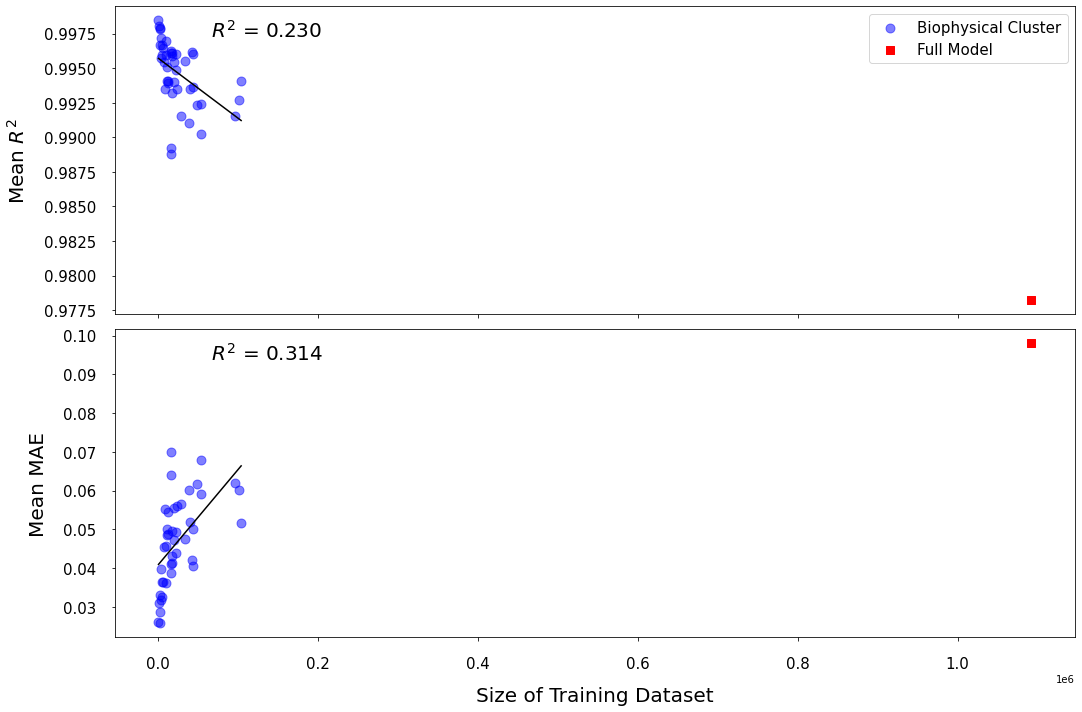

In [27]:
#### PLOT ACCURACY AND BIAS VS TRAINING SET SIZE ACROSS CROPS 
from sklearn.metrics import r2_score

fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (15,10), sharex = True, sharey = False)
ax[0].scatter(avg_train_len[:-1], clust_mean_meta_scores[:-1], c = "blue", alpha = .5, s = 80, label = "Biophysical Cluster")
ax[0].scatter(avg_train_len[-1], clust_mean_meta_scores[-1], c = "red", alpha = 1, s = 80, marker = 's', label = "Full Model")
z = np.polyfit(avg_train_len[:-1], clust_mean_meta_scores[:-1], 1)
p = np.poly1d(z)
ax[0].plot(np.arange(min(avg_train_len[:-1]), max(avg_train_len[:-1]), 10), p(np.arange(min(avg_train_len[:-1]), max(avg_train_len[:-1]), 10)), c = "black", linestyle = "-")
ax[0].text(0.1, 0.90, "$R^2$ = {:.3f}".format(r2_score(clust_mean_meta_scores[:-1], p(avg_train_len[:-1]))), transform=ax[0].transAxes, fontsize = 20)

ax[0].legend(fontsize=20)
ax[0].legend(loc='upper right', fontsize = 15)
ax[0].set_ylabel("Mean $R^2$", labelpad = 15)
ax[0].yaxis.label.set_size(20)

ax[1].scatter(avg_train_len[:-1], clust_mean_meta_MAE[:-1], c = "blue", alpha = .5, s = 80, label = "Biophysical Cluster Mean MAE")
ax[1].scatter(avg_train_len[-1], clust_mean_meta_MAE[-1], c = "red", alpha = 1, s = 80, marker = 's', label = "Full Model Mean MAE")
z = np.polyfit(avg_train_len[:-1], clust_mean_meta_MAE[:-1], 1)
p = np.poly1d(z)
ax[1].plot(np.arange(min(avg_train_len[:-1]), max(avg_train_len[:-1]), 10), p(np.arange(min(avg_train_len[:-1]), max(avg_train_len[:-1]), 10)), c = "black", linestyle = "-")
ax[1].text(0.1, 0.90, "$R^2$ = {:.3f}".format(r2_score(clust_mean_meta_MAE[:-1], p(avg_train_len[:-1]))), transform=ax[1].transAxes, fontsize = 20)

ax[1].set_xlabel("Size of Training Dataset", labelpad = 15)
ax[1].set_ylabel("Mean MAE", labelpad = 15)
ax[1].xaxis.label.set_size(20)
ax[1].yaxis.label.set_size(20)

ax[0].tick_params(axis='y', which='major', pad=15, labelsize = 15)
ax[1].tick_params(axis='both', which='major', pad=15, labelsize = 15)

fig.subplots_adjust(wspace=0, hspace=.05)
plt.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//Bias_Accuracy_v_train_size.jpg")

In [7]:
# cluster averages of soil and clim parameters
clust_precipavs = []
clust_FWCavs = []
clust_varavs = []
for i in range(43): 
    crop_spec = [clust[i].PRCPsumGS.mean() for clust in cluster_lists]
    clust_mean = sum(crop_spec) / len(crop_spec)
    clust_precipavs.append(clust_mean)
    
    crop_FWC = [clust[i].FWC_PROFILE.mean() for clust in cluster_lists]
    clust_FWC = sum(crop_FWC) / len(crop_FWC)
    clust_FWCavs.append(clust_FWC)
    
    crop_var = [clust[i].TMEANavGS.mean() for clust in cluster_lists]
    clust_var = sum(crop_var) / len(crop_var)
    clust_varavs.append(clust_var)

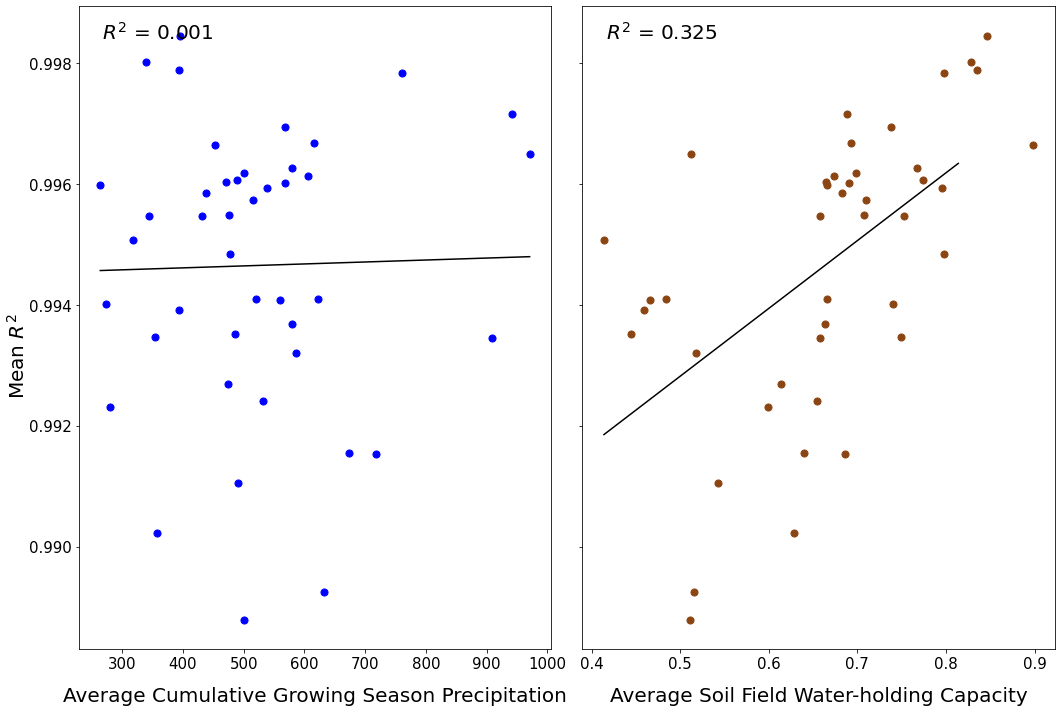

In [103]:
#### PLOT SCORE VERSUS CLUSTER CHARACTERISTICS 
from sklearn.metrics import r2_score
fig, ax = plt.subplots(ncols = 2, figsize = (15,10), sharey = True)

ax[0].scatter(clust_precipavs, clust_mean_meta_scores[:-1], s = 50, alpha = 1, c = "blue")
z = np.polyfit(clust_precipavs, clust_mean_meta_scores[:-1], 1)
p = np.poly1d(z)
ax[0].plot(np.arange(min(clust_precipavs), max(clust_precipavs), .1), p(np.arange(min(clust_precipavs), max(clust_precipavs), .1)), c = "black", linestyle = "-")
ax[0].text(0.05, 0.95, "$R^2$ = {:.3f}".format(r2_score(clust_mean_meta_scores[:-1], p(clust_precipavs))), transform=ax[0].transAxes, fontsize = 20)

ax[1].scatter(clust_FWCavs, clust_mean_meta_scores[:-1], s = 50, alpha = 1, c = "saddlebrown")
z = np.polyfit(clust_FWCavs, clust_mean_meta_scores[:-1], 1)
p = np.poly1d(z)
ax[1].plot(np.arange(min(clust_FWCavs), max(clust_FWCavs), .1), p(np.arange(min(clust_FWCavs), max(clust_FWCavs), .1)), c = "black", linestyle = "-")
ax[1].text(0.05, 0.95, "$R^2$ = {:.3f}".format(r2_score(clust_mean_meta_scores[:-1], p(clust_FWCavs))), transform=ax[1].transAxes, fontsize = 20)

ax[0].tick_params(axis='x', which='major', labelsize=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)
ax[0].set_xlabel("Average Cumulative Growing Season Precipitation", fontsize = 20, labelpad = 15)
ax[1].tick_params(axis='x', which='major', labelsize=15)
ax[1].tick_params(axis='y', which='major', labelsize=15)
ax[1].set_xlabel("Average Soil Field Water-holding Capacity", fontsize = 20, labelpad = 15)


# y axis label 
fig.supylabel("Mean $R^2$", rotation='vertical', fontsize = 20)
plt.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//R2_vs_clust_chars_scatter.jpg")


# Feature Importance Plots

In [8]:
# input leave one out scores for all targets, clusters - return mean variable importance among clusters
def get_mean_var_imp(loo_scores_AT, scores_AT):    
    targets = ["YLDG", "mean_OCPD_change"]
    all_features = ['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE', 'FNO3_AGG', 'PRCPsumGS', 'PRCPskGS', 'RADavGS',
                   'RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'RSDCa', 'FNO3_AGG_std', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
                   'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std', 'RSDCa_std']
    feat_lists = [['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE'], 
                         ['PRCPsumGS', 'PRCPskGS', 'RADavGS','RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
                   'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std'], 
                         ['FNO3_AGG', 'FNO3_AGG_std'], 
                         ['RSDCa', 'RSDCa_std'],
                         ['FNO3_AGG', 'FNO3_AGG_std', 'RSDCa', 'RSDCa_std']]
    mean_var_imp_AT = []
    var_imp_AT = []
    for i in range(len(targets)):    
        clust_diff_loo = []
        for c in range(len(loo_scores_AT[i])):
            clust_diff_loo.append([n1 - scores_AT[i][c] for n1 in loo_scores_AT[i][c]])
        var_imp_AT.append(clust_diff_loo)

        mean_var_imp = []
        for v in range(len(feat_lists) + len(all_features)):
            loo_diff = [clust_list[v] for clust_list in clust_diff_loo]
            mean_var_imp.append(sum(loo_diff) / len(loo_diff))

        # save the mean variable importance
        mean_var_imp_AT.append(mean_var_imp)
    return(mean_var_imp_AT, var_imp_AT)

In [9]:
# ..._pckl
# first level is crop 
# second level is target 
# third level is cluster
# fourth level is variable left out 

mean_var_imp_pckl = []
var_imp_pckl = []
for crop in range(len(crop_list)): 
    mean_var_imp_AT, var_imp_AT = get_mean_var_imp(loo_scores_pckl[crop], scores_pckl[crop])
    mean_var_imp_pckl.append(mean_var_imp_AT)
    var_imp_pckl.append(var_imp_AT)

In [10]:
# get scores for full model for each crop 
full_soil_scores = []
full_N_scores = []
full_clim_scores = []
full_res_scores = []
full_treat_scores = []
for scores in var_imp_pckl: 
    full_soil_scores.append(scores[1][-1][-5])
    full_N_scores.append(scores[1][-1][-3])
    full_clim_scores.append(scores[1][-1][-4])
    full_res_scores.append(scores[1][-1][-2])
    full_treat_scores.append(scores[1][-1][-1])
    
mean_full_soil = sum(full_soil_scores) / len(full_soil_scores) 
mean_full_clim = sum(full_clim_scores) / len(full_clim_scores) 
mean_full_N = sum(full_N_scores) / len(full_N_scores) 
mean_full_res = sum(full_res_scores) / len(full_res_scores) 
mean_full_treat = sum(full_treat_scores) / len(full_treat_scores)

### Plot Feature importance bar plots

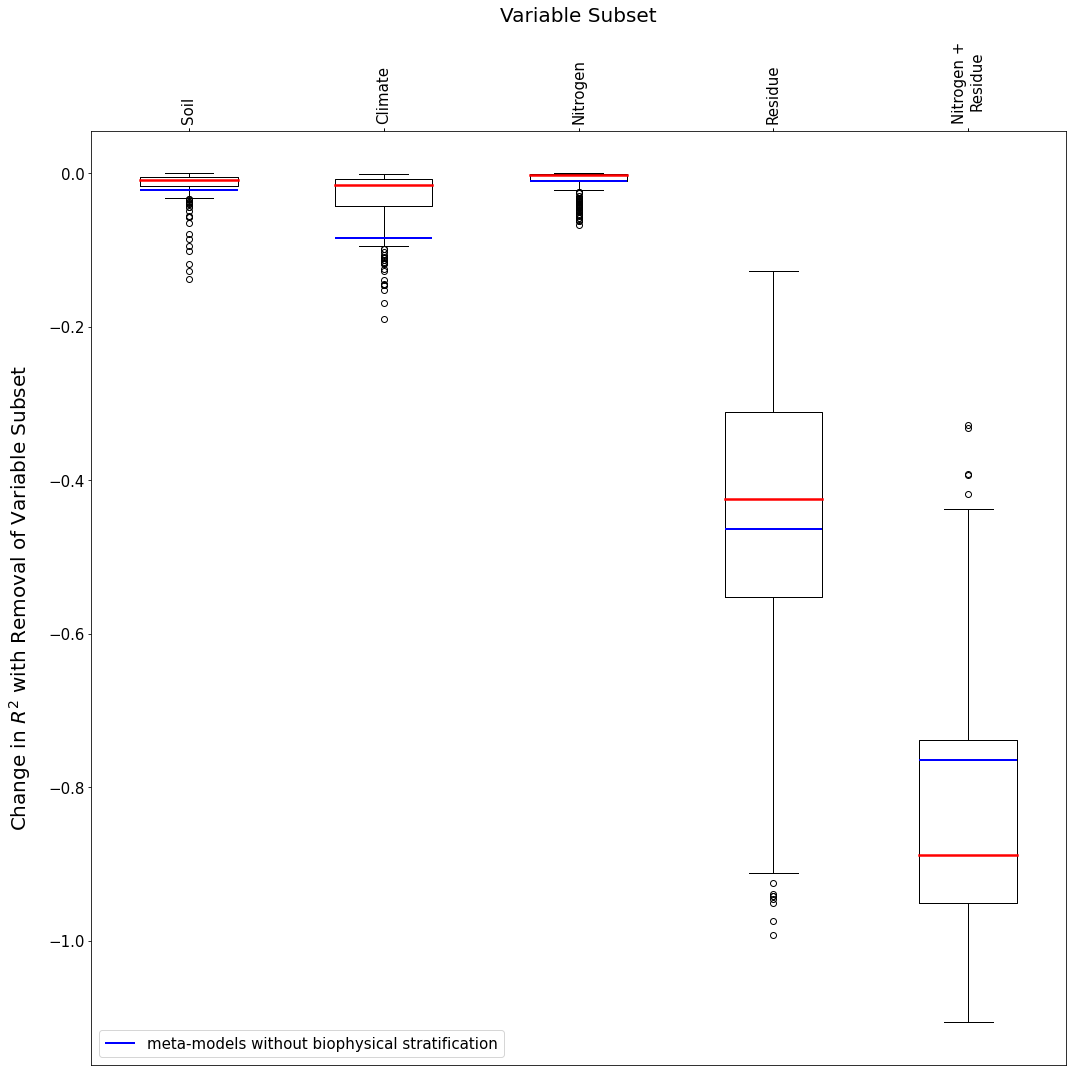

In [32]:
#### BAR PLOTS OF FEATURE IMPORTANCE 

# variables = ['Sand', 'Silt', 'OC', 'FWC', 'FNO3', 'PRCPsumGS', 'PRCPskGS', 'RADavGS',
#                'RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'RSDCa', 'FNO3_stdv', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
#                'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std', 'RSDCa_std']
variables = ['Soil', 'Climate', 'Nitrogen', 'Residue', 'Nitrogen + \nResidue']
# color_labels = {'Soil':'peru', 'Treatment':'orangered', "Climate":"teal", "Target": "white"}  
# color_labels = {'Predicting Yield, 35y Mean':'orangered', "Predicting Change OCPD, 35y Mean":"darkslategray"}  
# labels = list(color_labels.keys())
# handles = [plt.Rectangle((0,0),1,1, color=color_labels[label]) for label in labels]
medianprops = dict(linestyle='-', linewidth=2.5, color='red')


x = np.arange(len(variables))
width = .2
fig, ax = plt.subplots(figsize = (15,15))
ax.set_ylabel("Change in $R^2$ with Removal of Variable Subset", fontsize = 20, labelpad = 15)
ax.set_xlabel("Variable Subset", fontsize = 20, labelpad = 15)
ax.tick_params(axis='x', which='major', labelsize=15, rotation = 90)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_xticks(x, variables)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
# ax.legend(handles, labels, fontsize = 'xx-large', loc = "lower right")
ax.boxplot(score_arr, positions = x, labels = variables, medianprops=medianprops)

ax.hlines([mean_full_soil, mean_full_clim, mean_full_N, mean_full_res, mean_full_treat], x-.25, x+.25, colors = 'blue', linewidth = 2, label = "meta-models without biophysical stratification")
plt.legend(loc = "lower left", fontsize = 15)
plt.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//LOO_individ_boxplot.jpg")

### Plot feature importance averages for each cluster versus cluster properties 

In [30]:
# get LOO score across crops for each cluster
soil_scores = []
clim_scores = []
N_scores = []
res_scores = []
treat_scores = []
for i in range(43): 
    
    soil_scores.append([scores[1][i][-5] for scores in var_imp_pckl])
    clim_scores.append([scores[1][i][-4] for scores in var_imp_pckl])
    N_scores.append([scores[1][i][-3] for scores in var_imp_pckl])
    res_scores.append([scores[1][i][-2] for scores in var_imp_pckl])
    treat_scores.append([scores[1][i][-1] for scores in var_imp_pckl])
    
flat_soil = [item for sublist in soil_scores for item in sublist]
flat_clim = [item for sublist in clim_scores for item in sublist]
flat_n = [item for sublist in N_scores for item in sublist]
flat_res = [item for sublist in res_scores for item in sublist]
flat_treat = [item for sublist in treat_scores for item in sublist]

score_arr = np.array([flat_soil, flat_clim, flat_n, flat_res, flat_treat]).T


var_scores = []
for v in range(22):
    not_flat = []
    for i in range(43): 
        not_flat.append([scores[1][i][v] for scores in var_imp_pckl])
    var_scores.append([item for sublist in not_flat for item in sublist])
        
ind_array = np.array(var_scores).T


In [13]:
# cluster LOO averages across crops 
clust_res_means = [sum(scores)/len(scores) for scores in res_scores]
clust_n_means = [sum(scores)/len(scores) for scores in N_scores]
clust_clim_means = [sum(scores)/len(scores) for scores in clim_scores]
clust_soil_means = [sum(scores)/len(scores) for scores in soil_scores]

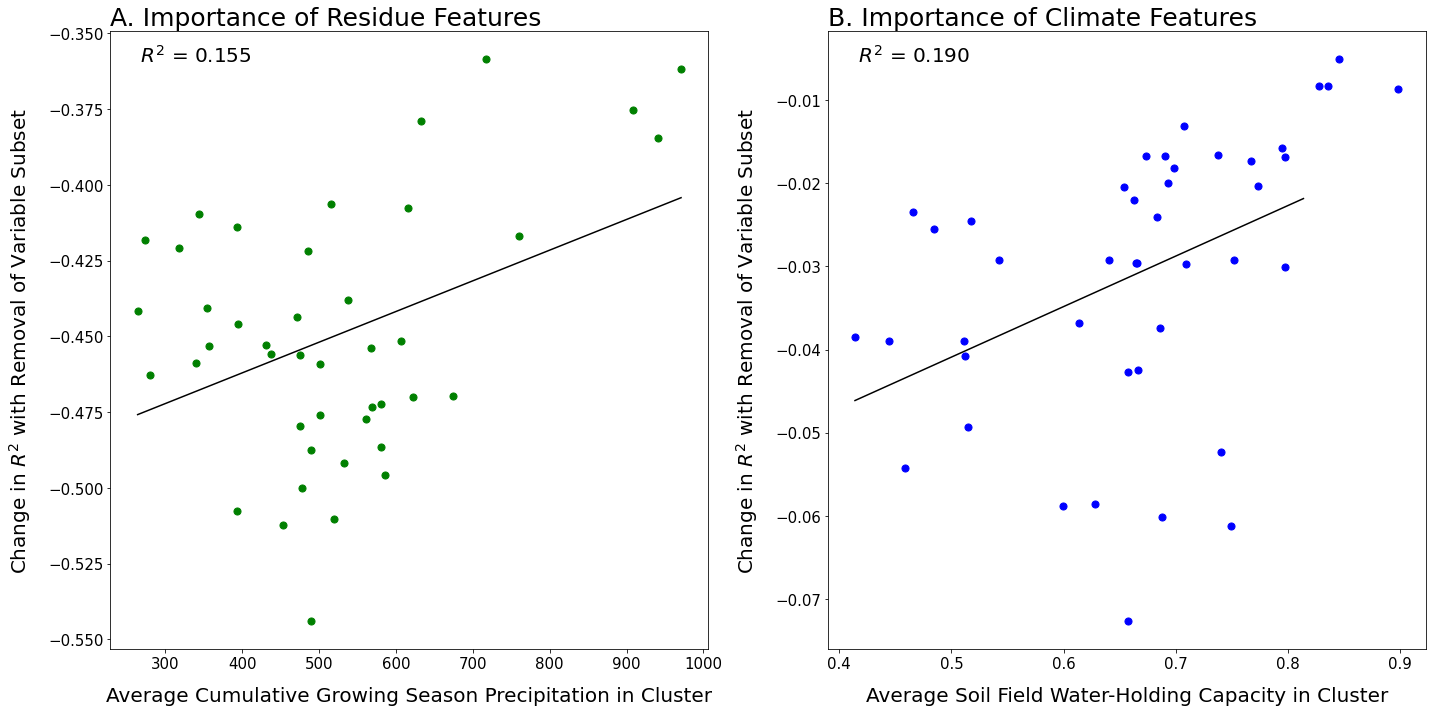

In [17]:
#### PLOT IMPORTANCE VERSUS CLUSTER CHARACTERISTICS 
from sklearn.metrics import r2_score
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))

ax[0].set_title("A. Importance of Residue Features", fontsize = 25, loc = 'left')
ax[0].scatter(clust_precipavs, clust_res_means, s = 50, alpha = 1, c = "green", label = "Residue")
ax[0].set_ylabel("Change in $R^2$ with Removal of Variable Subset", rotation='vertical', fontsize = 20, labelpad = 15)
ax[0].set_xlabel("Average Cumulative Growing Season Precipitation in Cluster", fontsize = 20, labelpad = 15)
z = np.polyfit(clust_precipavs, clust_res_means, 1)
p = np.poly1d(z)
ax[0].plot(np.arange(min(clust_precipavs), max(clust_precipavs), .1), p(np.arange(min(clust_precipavs), max(clust_precipavs), .1)), c = "black", linestyle = "-")
ax[0].text(0.05, 0.95, "$R^2$ = {:.3f}".format(r2_score(clust_res_means, p(clust_precipavs))), transform=ax[0].transAxes, fontsize = 20)
# ax[0].legend(loc = "lower right", fontsize = 20)

ax[1].set_title("B. Importance of Climate Features", fontsize = 25, loc = 'left')
ax[1].scatter(clust_FWCavs, clust_clim_means, s = 50, alpha = 1, c = "blue", label = "Climate")
ax[1].set_ylabel("Change in $R^2$ with Removal of Variable Subset", rotation='vertical', fontsize = 20, labelpad = 15)
ax[1].set_xlabel("Average Soil Field Water-Holding Capacity in Cluster", fontsize = 20, labelpad = 15)
z = np.polyfit(clust_FWCavs, clust_clim_means, 1)
p = np.poly1d(z)
ax[1].plot(np.arange(min(clust_FWCavs), max(clust_FWCavs), .1), p(np.arange(min(clust_FWCavs), max(clust_FWCavs), .1)), c = "black", linestyle = "-")
ax[1].text(0.05, 0.95, "$R^2$ = {:.3f}".format(r2_score(clust_clim_means, p(clust_FWCavs))), transform=ax[1].transAxes, fontsize = 20)
# ax[2].legend(loc = "lower right", fontsize = 20)


ax[0].tick_params(axis='x', which='major', labelsize=15)
ax[0].tick_params(axis='y', which='major', labelsize=15)
ax[1].tick_params(axis='x', which='major', labelsize=15)
ax[1].tick_params(axis='y', which='major', labelsize=15)
# fig.legend(loc='upper right', bbox_to_anchor=[1.15, 1], fontsize = 20)

# y axis label 
plt.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//LOO_subset_RELATIONSIPS.jpg")



### Plot Feature Importance By Crop 

In [106]:
crop_res_means = []
for i in range(8):
        take_mean = [scores[i] for scores in res_scores]
        crop_res_means.append(sum(take_mean)/len(take_mean))
crop_n_means = []
for i in range(8):
        take_mean = [scores[i] for scores in N_scores]
        crop_n_means.append(sum(take_mean)/len(take_mean))
crop_clim_means = []
for i in range(8):
        take_mean = [scores[i] for scores in clim_scores]
        crop_clim_means.append(sum(take_mean)/len(take_mean))
crop_soil_means = []
for i in range(8):
        take_mean = [scores[i] for scores in soil_scores]
        crop_soil_means.append(sum(take_mean)/len(take_mean))

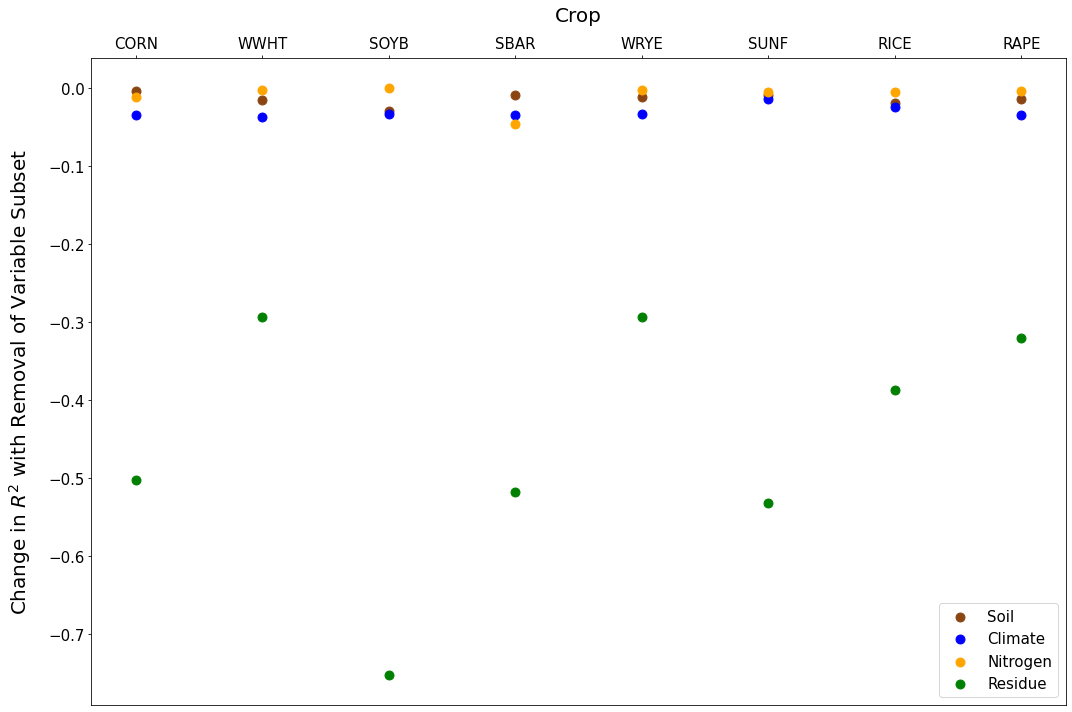

In [331]:
#### PLOT FEATURE IMPORTANCE BY CROP 
crops = ['CORN', 'WWHT', 'SOYB', 'SBAR', 'WRYE', 'SUNF', 'RICE', 'RAPE']
x = np.arange(len(crops))

fig, ax = plt.subplots(figsize = (15,10))
ax.set_ylabel("Change in $R^2$ with Removal of Variable Subset", fontsize = 20, labelpad = 15)
ax.set_xlabel("Crop", fontsize = 20, labelpad = 15)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_xticks(x, crops)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.scatter(x, crop_soil_means, s = 80, alpha = 1, c = "saddlebrown", label = "Soil")
ax.scatter(x, crop_clim_means, s = 80, alpha = 1, c = "blue", label = "Climate")
ax.scatter(x, crop_n_means, s = 80, alpha = 1, c = "orange", label = "Nitrogen")
ax.scatter(x, crop_res_means, s = 80, alpha = 1, c = "green", label = "Residue")
ax.legend(fontsize=20, title = "Variable Subset")
ax.legend(loc='lower right', fontsize = 15)
plt.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//LOO_subset_by_crop_scatter.jpg")

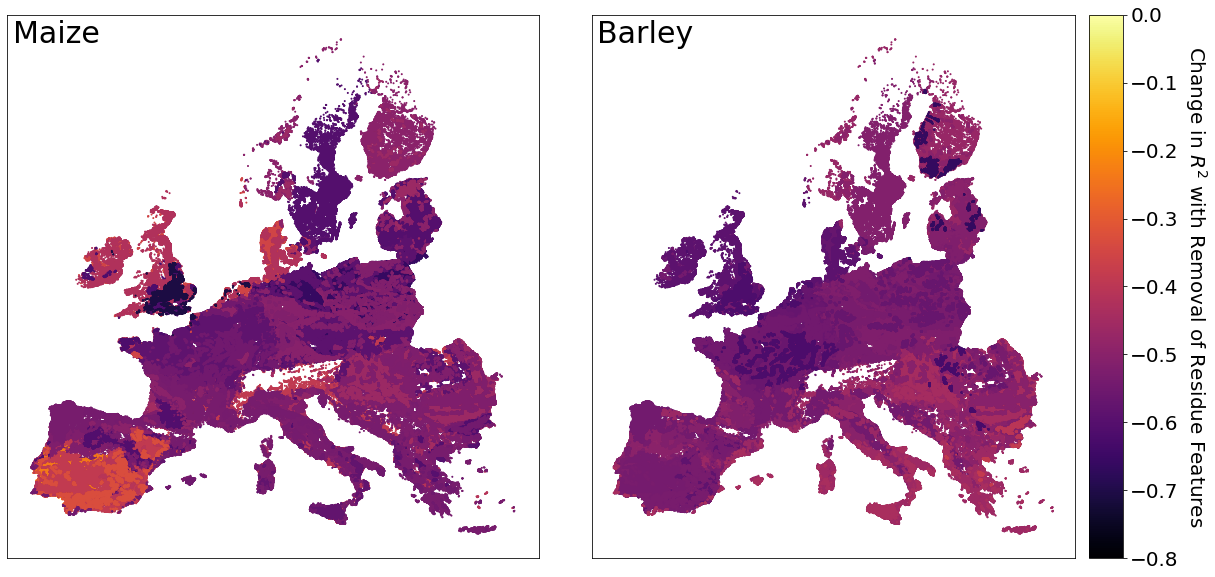

In [67]:
### Map of side by side feature importance maps 
loc_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt")
from mpl_toolkits.axes_grid1 import make_axes_locatable

# MOSAIC PLOT OF CLUSTERS AND FINAL SUBGROUPS
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10),
                              constrained_layout=False)
plt.subplots_adjust(wspace=.1, hspace=0)

# define colormaps
colm = cm.get_cmap('inferno')

# plot maize residue feature importance for each cluster 
axs[0].text(.01, .99, "Maize", ha='left', va='top', transform=axs[0].transAxes, fontsize = 30)
X_list = []
Y_list = []
val_list = []
for c in range(43): 
    pulled_pts = loc_df[loc_df.SimUID.isin(list(cluster_lists[0][c].SimUID.unique()))]
    X_list.append(list(pulled_pts.X))
    Y_list.append(list(pulled_pts.Y))
    val_list.append([res_scores[c][0]]*len(pulled_pts))
flat_X = [item for sublist in X_list for item in sublist]
flat_Y = [item for sublist in Y_list for item in sublist]
flat_val = [item for sublist in val_list for item in sublist]

axs[0].scatter(flat_X, flat_Y, s = 1, c = flat_val, cmap = colm, vmin=-.8, vmax=0, edgecolor = None, alpha = 1)
axs[0].grid(False)
axs[0].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

# plot sbarl residue feature importance 
axs[1].text(.01, .99, "Barley", ha='left', va='top', transform=axs[1].transAxes, fontsize = 30)
X_list = []
Y_list = []
val_list = []
for c in range(43): 
    pulled_pts = loc_df[loc_df.SimUID.isin(list(cluster_lists[3][c].SimUID.unique()))]
    X_list.append(list(pulled_pts.X))
    Y_list.append(list(pulled_pts.Y))
    val_list.append([res_scores[c][3]]*len(pulled_pts))
flat_X = [item for sublist in X_list for item in sublist]
flat_Y = [item for sublist in Y_list for item in sublist]
flat_val = [item for sublist in val_list for item in sublist]

scat = axs[1].scatter(flat_X, flat_Y, s = 1, c = flat_val, cmap = colm, vmin=-.8, vmax=0, edgecolor = None, alpha = 1)
axs[1].grid(False)
axs[1].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
# colorbar
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size="7%", pad=0.2,)
cbar = fig.colorbar(scat, cax = cax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Change in $R^2$ with Removal of Residue Features', rotation = 270, fontsize = 20, labelpad = 30)


plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//res_feat_imp_MAPS.jpg", bbox_inches='tight')

# Response Curve Plots 

In [34]:
loc_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt")

In [70]:
def get_fxn(v1, target, cluster, regressors_AT): 
    # get the index of the target
    targets = ["YLDG", "mean_OCPD_change"]
    target_index = targets.index(target)
    
    # get the index of the variables
    variables = ['SAND_PROFILE', 'SILT_PROFILE', 'OC_TOP', 'FWC_PROFILE', 'FNO3_AGG', 'PRCPsumGS', 'PRCPskGS', 'RADavGS',
           'RADskGS', 'TMEANavGS', 'TMEANskGS', 'PETavGS', 'RSDCa', 'FNO3_AGG_std', 'PRCPsumGS_std', 'PRCPskGS_std', 'RADavGS_std',
           'RADskGS_std', 'TMEANavGS_std', 'TMEANskGS_std', 'PETavGS_std', 'RSDCa_std']
    predictor_index1 = variables.index(v1)
    
    # get regressor, get mean coefficients of bagged regressor estimators
    r = regressors_AT[target_index][cluster]
    coeff_means = np.mean([est.named_steps.ridge.coef_ for est in r.estimators_], axis = 0)
    powers = r.estimators_[0].named_steps.poly.powers_

    # get linear coeffs for variable
    x1v1 = [0]*len(variables)
    x1v1[predictor_index1] = 1 
    ind_x1v1_coeff = np.flatnonzero(np.equal(powers, x1v1).all(1))[0]
    coeff_x1v1 = coeff_means[ind_x1v1_coeff]
    
    # get quadratic coeffs for variables
    x2v1 = [0]*len(variables)
    x2v1[predictor_index1] = 2  
    ind_x2v1_coeff = np.flatnonzero(np.equal(powers, x2v1).all(1))[0]
    coeff_x2v1 = coeff_means[ind_x2v1_coeff]
    
    return (coeff_x1v1, coeff_x2v1)
    

In [71]:
# curve function 
def objective(x, a, b):
	return a * x + b * x**2       

In [74]:
RSDCa_y_list = []
for reg in regressors_pckl: 
    for i in range(44): 
        c1, c2 = get_fxn("RSDCa", "mean_OCPD_change", i, reg)
        RSDCa_y_list.append(objective(np.arange(-3,3,.1), c1, c2))
        
all_RSDCa_y = np.vstack(RSDCa_y_list[:-1])
mean_RSDCa_y = all_RSDCa_y.mean(axis = 0)
max_RSDCa_y = all_RSDCa_y.max(axis = 0)
min_RSDCa_y = all_RSDCa_y.min(axis = 0)
full_RSDCa_y = list(RSDCa_y_list[-1])

FNO3_y_list = []
for i in range(43):
    pckl_list = []
    for reg in regressors_pckl: 
        c1, c2 = get_fxn("PRCPsumGS", "mean_OCPD_change", i, reg)
        pckl_list.append(objective(np.arange(-3,3,.1), c1, c2))
    FNO3_y_list.append(np.vstack(pckl_list).mean(axis = 0))

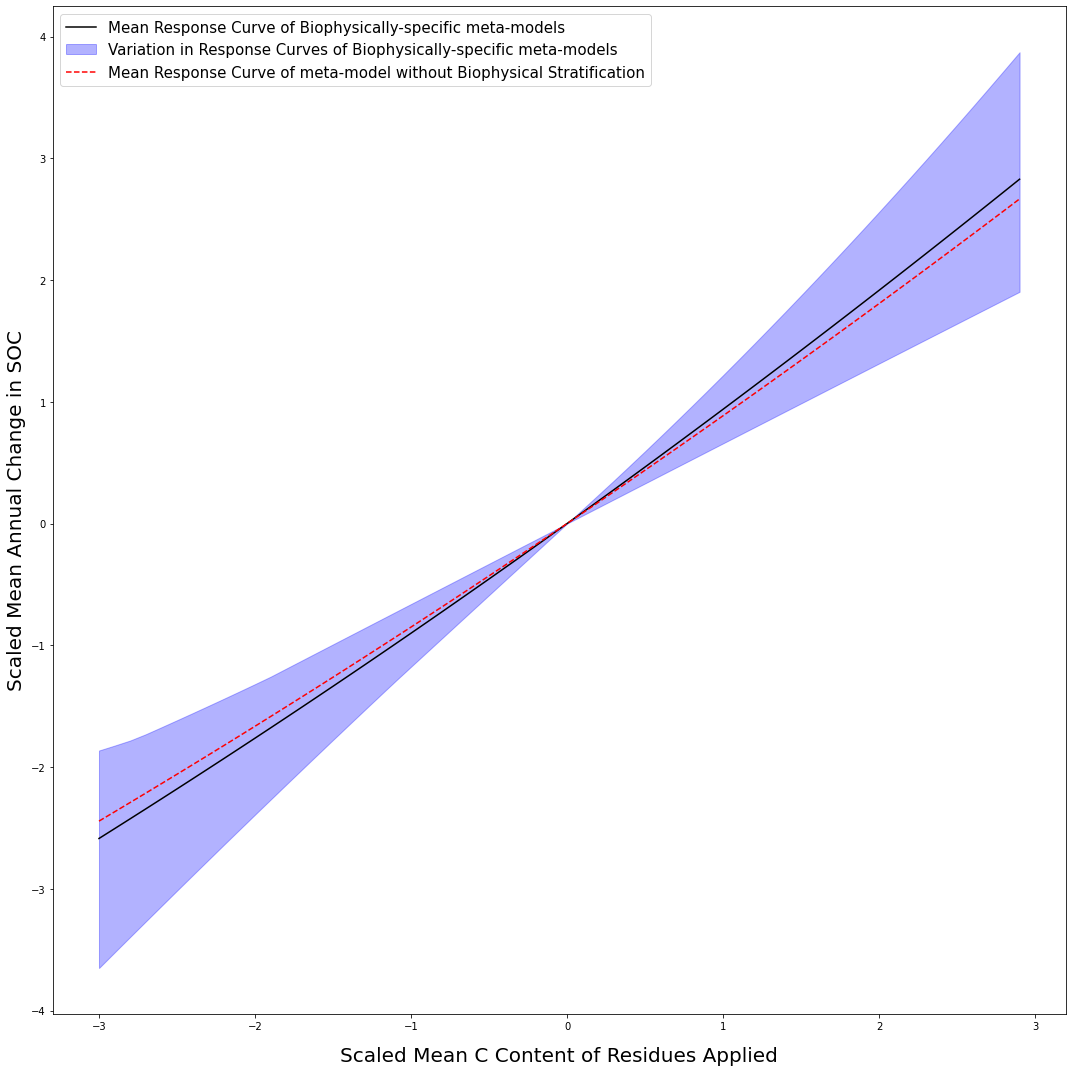

In [114]:
#### PLOT RESPONSE OF SOC TO RSDCA AS ONE PLOT WITH ERROR MARGIN 
x = np.arange(-3,3,.1)
fig, ax = plt.subplots(figsize = (15,15))
ax.plot(x, mean_RSDCa_y, c = "black", label = "Mean Response Curve of Biophysically-specific meta-models")
ax.fill_between(x, min_RSDCa_y, max_RSDCa_y, color = "blue", alpha = .3, label = "Variation in Response Curves of Biophysically-specific meta-models")
ax.plot(x, full_RSDCa_y, color = "red", linestyle = "--", label = "Mean Response Curve of meta-model without Biophysical Stratification")
ax.set_xlabel("Scaled Mean C Content of Residues Applied", fontsize = 20, labelpad = 15)
ax.set_ylabel("Scaled Mean Annual Change in SOC", fontsize = 20, labelpad = 5)
ax.legend(loc = "upper left", fontsize = 15)
plt.tight_layout()
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//RSDCa_response_curve.jpg")

In [69]:
clim_info = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//_SimUData//climate_PCA_x_simUID.csv")[['SimUID', 'k_mean_cluster']]
loc_df = pd.read_csv("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//SimUID_Pts_210_240.txt")
merged1 = loc_df.merge(clim_info, how = 'left', on = 'SimUID')
merged1.dropna(inplace = True)

In [68]:
p10 = sns.color_palette("tab10", 10)
colors = [p10[5]]*4 + [p10[9]]*5 + [p10[1]]*4 + [p10[3]]*4 + [p10[6]]*4 + [p10[0]]*5 + [p10[8]]*4 + [p10[7]]*4 + [p10[2]]*4 + [p10[4]]*5

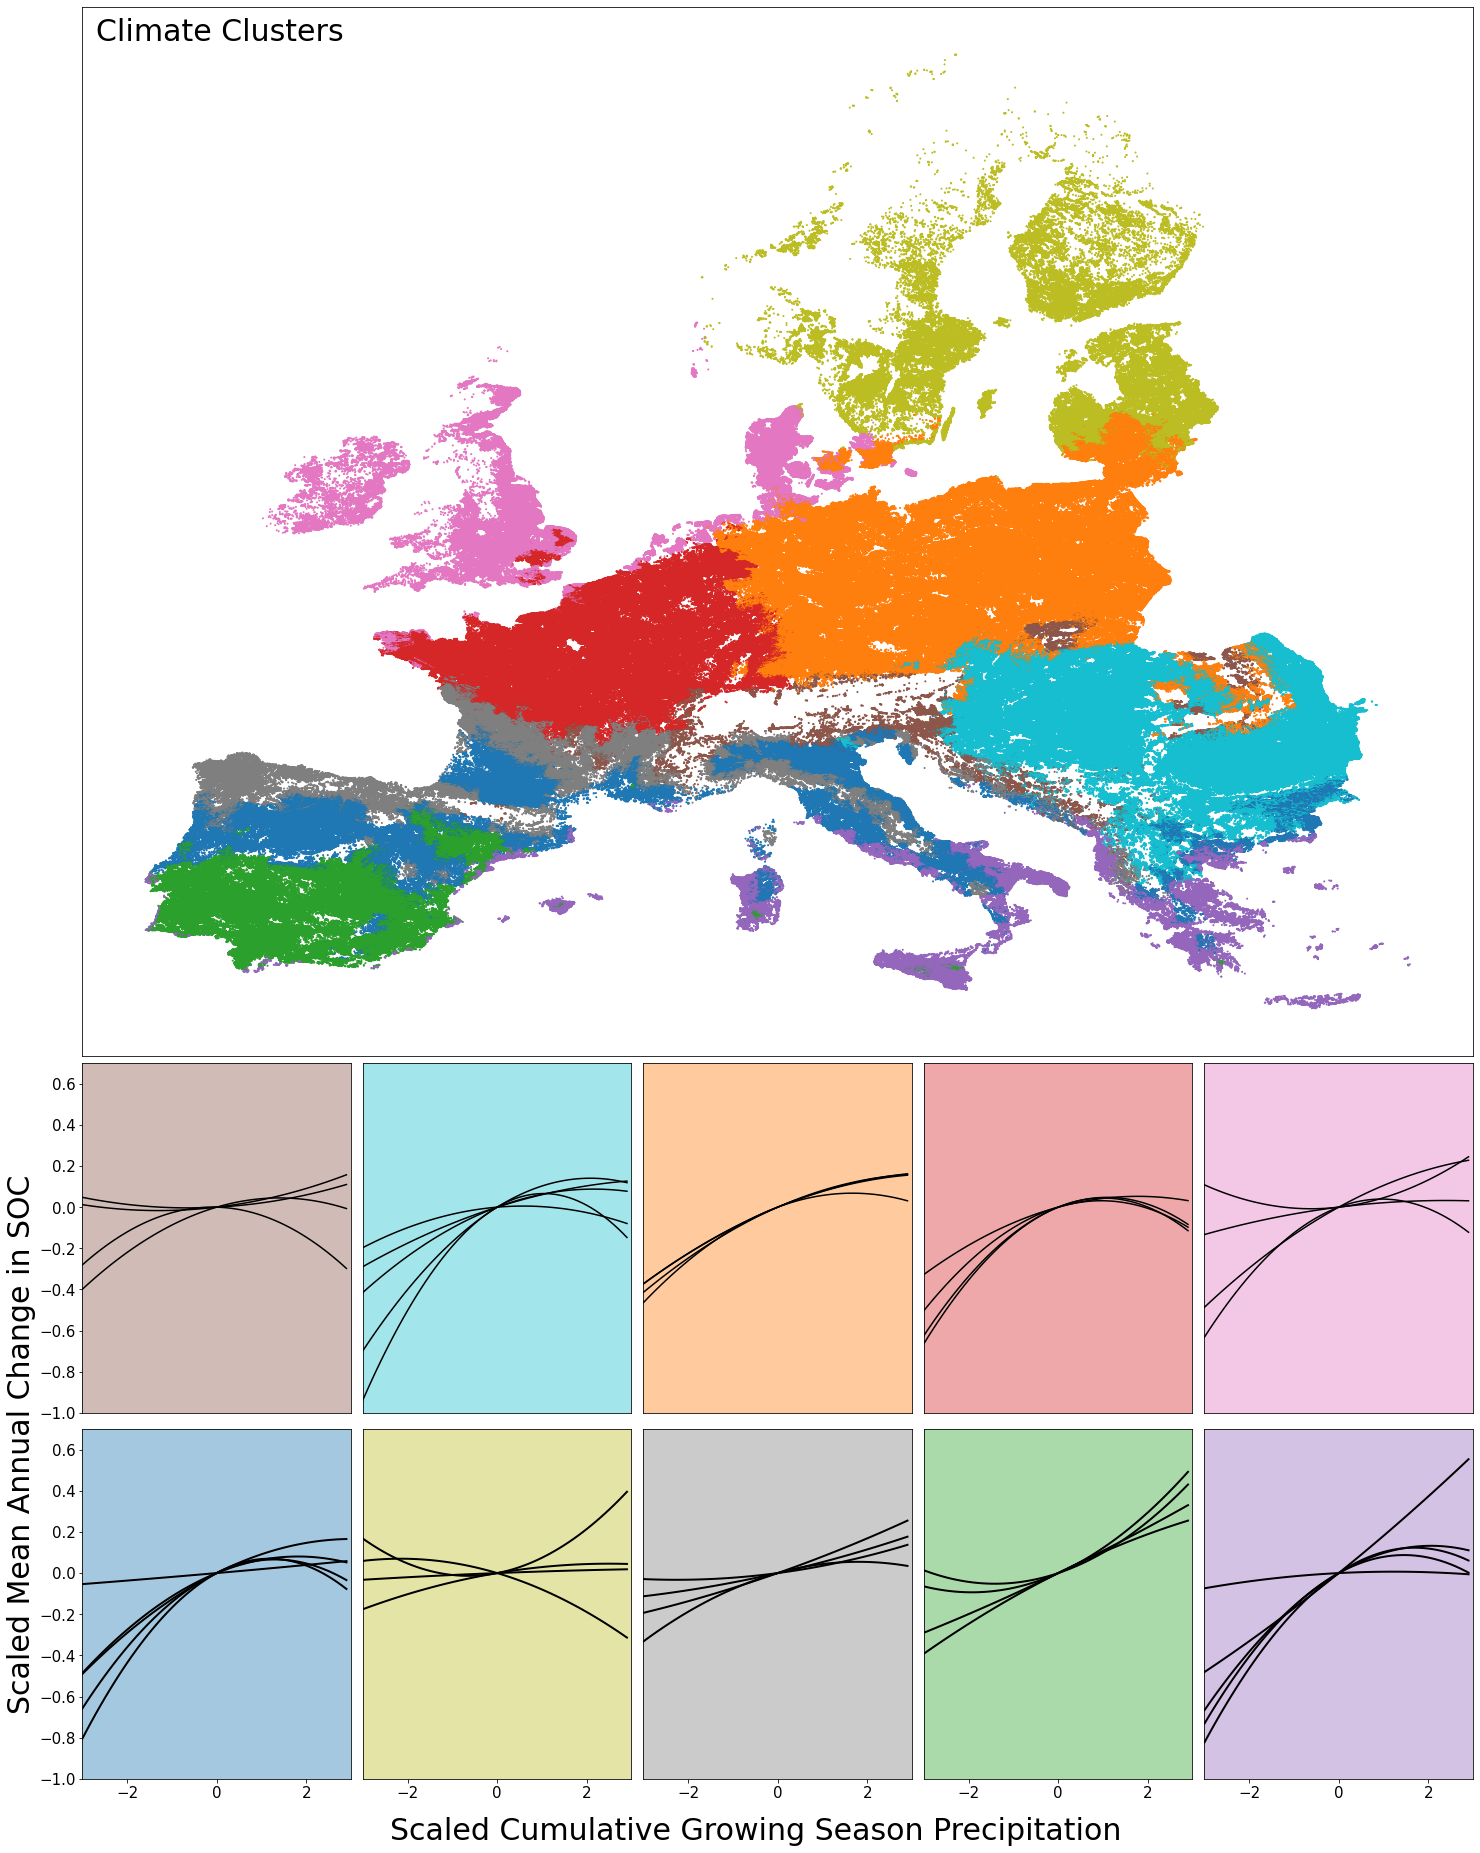

In [102]:
x = np.arange(-3,3,.1)
a = .4

fig, axs = plt.subplot_mosaic([['MAP', 'MAP', 'MAP', 'MAP', 'MAP'],
                               ['MAP', 'MAP', 'MAP', 'MAP', 'MAP'],
                               ['MAP', 'MAP', 'MAP', 'MAP', 'MAP'],
                               ['0', '1', '2', '3', '4'],
                               ['5', '6', '7', '8', '9']], figsize = (20, 25),
                              constrained_layout=True)

# MAP 
colm = cm.get_cmap('tab10', 10)
axs['MAP'].text(.01, .99, "Climate Clusters", ha='left', va='top', transform=axs['MAP'].transAxes, fontsize = 30)
axs['MAP'].scatter(merged1.X, merged1.Y, s = 1, c = merged1.k_mean_cluster, cmap = colm, edgecolor = None, alpha = 1)
axs['MAP'].grid(False)
axs['MAP'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

# PLOT RESPONSE CURVES 
fig.text(0.5, -0.02, "Scaled Cumulative Growing Season Precipitation", ha='center', fontsize = 30)
fig.text(-0.02, 0.2, 'Scaled Mean Annual Change in SOC', va='center', rotation='vertical', fontsize = 30)

for i in range(4):
    axs['0'].plot(x, FNO3_y_list[i], c = "black")
    axs['0'].patch.set_facecolor(colors[i])
    axs['0'].patch.set_alpha(a)
    axs['0'].set_xlim([-3, 3])
    axs['0'].set_ylim([-1, .7])
    axs['0'].tick_params(left = True, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
    
for i in range(4,9):
    axs['1'].plot(x, FNO3_y_list[i], c = "black")
    axs['1'].patch.set_facecolor(colors[i])
    axs['1'].patch.set_alpha(a)
    axs['1'].set_xlim([-3, 3])
    axs['1'].set_ylim([-1, .7])
    axs['1'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
for i in range(9,13):
    axs['2'].plot(x, FNO3_y_list[i], c = "black")
    axs['2'].patch.set_facecolor(colors[i])
    axs['2'].patch.set_alpha(a)
    axs['2'].set_xlim([-3, 3])
    axs['2'].set_ylim([-1, .7])
    axs['2'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
for i in range(13,17):
    axs['3'].plot(x, FNO3_y_list[i], c = "black")
    axs['3'].patch.set_facecolor(colors[i])
    axs['3'].patch.set_alpha(a)
    axs['3'].set_xlim([-3, 3])
    axs['3'].set_ylim([-1, .7])
    axs['3'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
for i in range(17,21):
    axs['4'].plot(x, FNO3_y_list[i], c = "black")
    axs['4'].patch.set_facecolor(colors[i])
    axs['4'].patch.set_alpha(a)
    axs['4'].set_xlim([-3, 3])
    axs['4'].set_ylim([-1, .7])
    axs['4'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
for i in range(21,26):    
    axs['5'].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    axs['5'].patch.set_facecolor(colors[i])
    axs['5'].patch.set_alpha(a)
    axs['5'].set_xlim([-3, 3])
    axs['5'].set_ylim([-1, .7])

for i in range(26,30):
    axs['6'].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    axs['6'].patch.set_facecolor(colors[i])
    axs['6'].patch.set_alpha(a)
    axs['6'].set_xlim([-3, 3])
    axs['6'].set_ylim([-1, .7])
    axs['6'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
for i in range(30,34):
    axs['7'].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    axs['7'].patch.set_facecolor(colors[i])
    axs['7'].patch.set_alpha(a)
    axs['7'].set_xlim([-3, 3])
    axs['7'].set_ylim([-1, .7])
    axs['7'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
for i in range(34,38):
    axs['8'].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    axs['8'].patch.set_facecolor(colors[i])
    axs['8'].patch.set_alpha(a)
    axs['8'].set_xlim([-3, 3])
    axs['8'].set_ylim([-1, .7])
    axs['8'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)
for i in range(38,43):
    axs['9'].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    axs['9'].patch.set_facecolor(colors[i])
    axs['9'].patch.set_alpha(a)
    axs['9'].set_xlim([-3, 3])
    axs['9'].set_ylim([-1, .7])
    axs['9'].tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = True)

for i, ax in enumerate(fig.axes):
    ax.tick_params(labelsize = 15)  
        
    
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//MAP_plus_response_curve.jpg", bbox_inches='tight')

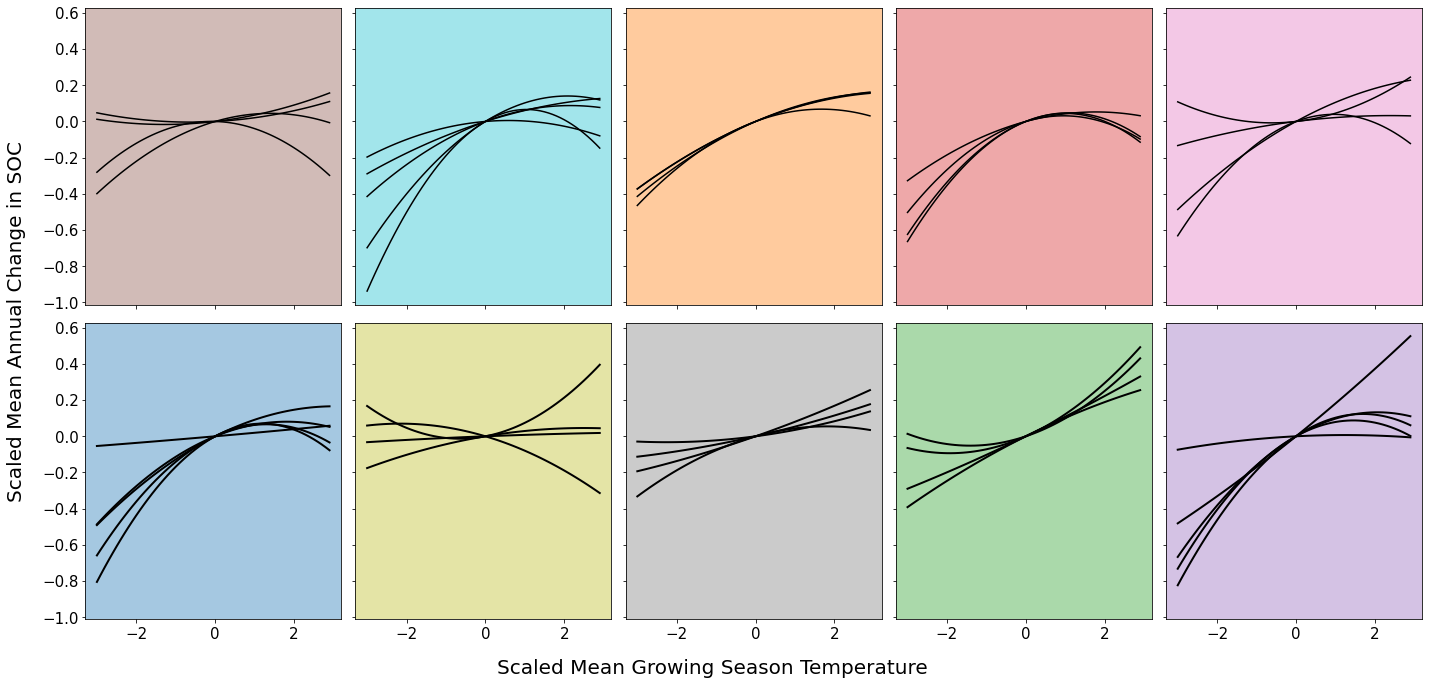

In [87]:
#### plot lines together 
x = np.arange(-3,3,.1)
a = .4

    
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (20,10), sharex = True, sharey = True)
fig.text(0.5, 0.01, "Scaled Mean Growing Season Temperature", ha='center', fontsize = 20)
fig.text(0.01, 0.5, 'Scaled Mean Annual Change in SOC', va='center', rotation='vertical', fontsize = 20)

# fig.supxlabel("Scaled Mean Cumulative Growing Season Precipitation", fontsize = 20)
# fig.supylabel('Scaled Mean Annual Change in SOC', rotation='vertical', fontsize = 20)

for i in range(4):
    ax[0][0].plot(x, FNO3_y_list[i], c = "black")
    ax[0][0].patch.set_facecolor(colors[i])
    ax[0][0].patch.set_alpha(a)
    
for i in range(4,9):
    ax[0][1].plot(x, FNO3_y_list[i], c = "black")
    ax[0][1].patch.set_facecolor(colors[i])
    ax[0][1].patch.set_alpha(a)
for i in range(9,13):
    ax[0][2].plot(x, FNO3_y_list[i], c = "black")
    ax[0][2].patch.set_facecolor(colors[i])
    ax[0][2].patch.set_alpha(a)
for i in range(13,17):
    ax[0][3].plot(x, FNO3_y_list[i], c = "black")
    ax[0][3].patch.set_facecolor(colors[i])
    ax[0][3].patch.set_alpha(a)
for i in range(17,21):
    ax[0][4].plot(x, FNO3_y_list[i], c = "black")
    ax[0][4].patch.set_facecolor(colors[i])
    ax[0][4].patch.set_alpha(a)
    
for i in range(21,26):    
    ax[1][0].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    ax[1][0].patch.set_facecolor(colors[i])
    ax[1][0].patch.set_alpha(a)
for i in range(26,30):
    ax[1][1].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    ax[1][1].patch.set_facecolor(colors[i])
    ax[1][1].patch.set_alpha(a)
for i in range(30,34):
    ax[1][2].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    ax[1][2].patch.set_facecolor(colors[i])
    ax[1][2].patch.set_alpha(a)
for i in range(34,38):
    ax[1][3].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    ax[1][3].patch.set_facecolor(colors[i])
    ax[1][3].patch.set_alpha(a)
for i in range(38,43):
    ax[1][4].plot(x, FNO3_y_list[i], c = "black", linewidth = 2)
    ax[1][4].patch.set_facecolor(colors[i])
    ax[1][4].patch.set_alpha(a)

for i, ax in enumerate(fig.axes):
    ax.tick_params(labelsize = 15)    
plt.tight_layout(rect=[0.02, 0.04, 1, 0.95])
plt.savefig("//Users//taraippolito//Desktop//Desktop_Tara’s_MacBook_Pro//EPIC_local//paper_figures//TMEAN_response_curve.jpg")